In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x57916000 @  0x7f3f40ac22a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
# import libraries
import numpy as np

#random seed(for reproducibility)
seed = 1
#set random seed for numpy
np.random.seed(seed)
#set random seed for torch
torch.manual_seed(seed)

Obtain the data

In [0]:
from torchvision import datasets
import torchvision.transforms as transforms

#number of subprocessors to use for data loading
num_workers = 0
#how many  samples per batch to load
batch_size = 20

#convert data to tensors
transform = transforms.ToTensor()

#choose the training and testing data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

#prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

Processing...
Done!


Visualize training data

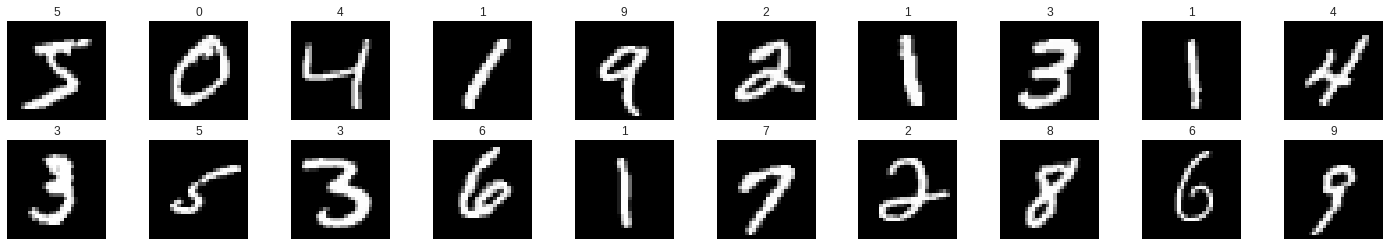

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

**Encoder**
The encoder is made of a series of layers that are responsible for taking in as input a 28 by 28 MNIST image and learning to encode it into a 16-dimensional output vector.

**First Layer: Convolutional Layer**

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class ConvLayer(nn.Module):
  def __init__(self, in_channels=1, out_channels=256):
    super(ConvLayer, self).__init__()
    # defining a convolutional layer of the specified size
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=9, stride=1, padding=0)
    
  def forward(self, x):
    # applying a ReLu activation to the outputs of the conv layer
    features = F.relu(self.conv(x))# will have dimensions (batch_size, 20, 20, 256)
    return features

**Second Layer: Primary Capsules**

In [0]:
class PrimaryCaps(nn.Module):
  def __init__(self, num_capsules=8, in_channels=256, out_channels=32):
    super(PrimaryCaps, self).__init__()
    
    self.capsules = nn.ModuleList([nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=9, stride=2, padding=0) for i in range(num_capsules)])
    
  def forward(self, x):
    # get batch size of inputs
    batch_size = x.size(0)
    # reshape convolutional layer outputs to be (batch_size, vector_dim=1152, 1)
    u = [capsule(x).view(batch_size, 32 * 6 * 6, 1) for capsule in self.capsules]
    # stack up output vectors, u, one for each capsule
    u = torch.cat(u, dim=-1)
    # squashing the stack of vectors
    u_squash = self.squash(u)
    return u_squash
  
  def squash(self, input_tensor):
    squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
    scale = squared_norm / (1 + squared_norm) # normalization coeff
    output_tensor = scale * input_tensor / torch.sqrt(squared_norm)    
    return output_tensor

**Third Layer: Digit Capsules**

In [0]:
## to get transpose softmax function
def softmax(input_tensor, dim=1):
  # transpose input
  transposed_input = input_tensor.transpose(dim, len(input_tensor.size()) - 1)
  # calculate softmax
  softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
  # un-transpose result
  return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input_tensor.size()) - 1)

Dynamic Routing

In [0]:
def dynamic_routing(b_ij, u_hat, squash, routing_iterations=3):
  # update b_ij, c_ij for number of routing iterations
  for iteration in range(routing_iterations):
    # softmax calculation of coupling coefficients, c_ij
    c_ij = softmax(b_ij, dim=2)

    # calculating total capsule inputs, s_j = sum(c_ij*u_hat)
    s_j = (c_ij * u_hat).sum(dim=2, keepdim=True)

    # squashing to get a normalized vector output, v_j
    v_j = squash(s_j)

    # if not on the last iteration, calculate agreement and new b_ij
    if iteration < routing_iterations - 1:
      # agreement
      a_ij = (u_hat * v_j).sum(dim=-1, keepdim=True)
            
      # new b_ij
      b_ij = b_ij + a_ij
    
  return v_j # return latest v_j

Digit Capsules

In [0]:
# it will also be relevant
TRAIN_ON_GPU = torch.cuda.is_available()

if(TRAIN_ON_GPU):
  print('Training on GPU!')
else:
  print('Only CPU available')

Training on GPU!


In [0]:
class DigitCaps(nn.Module):
  def __init__(self, num_capsules=10, previous_layer_nodes=32*6*6, in_channels=8, out_channels=16):
    
    super(DigitCaps, self).__init__()

    # setting class variables
    self.num_capsules = num_capsules
    self.previous_layer_nodes = previous_layer_nodes # vector input (dim=1152)
    self.in_channels = in_channels # previous layer's number of capsules

    # starting out with a randomly initialized weight matrix, W
    # these will be the weights connecting the PrimaryCaps and DigitCaps layers
    self.W = nn.Parameter(torch.randn(num_capsules, previous_layer_nodes, in_channels, out_channels))

  def forward(self, u):
    # adding batch_size dims and stacking all u vectors
    u = u[None, :, :, None, :]
    # 4D weight matrix
    W = self.W[:, None, :, :, :]
        
    # calculating u_hat = W*u
    u_hat = torch.matmul(u, W)
    # getting the correct size of b_ij
    # setting them all to 0, initially
    b_ij = torch.zeros(*u_hat.size())
        
    # moving b_ij to GPU, if available
    if TRAIN_ON_GPU:
      b_ij = b_ij.cuda()

    # update coupling coefficients and calculate v_j
    v_j = dynamic_routing(b_ij, u_hat, self.squash, routing_iterations=3)

    return v_j # return final vector outputs
    
    
  def squash(self, input_tensor):
    # same squash function as before
    squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
    scale = squared_norm / (1 + squared_norm) # normalization coeff
    output_tensor = scale * input_tensor / torch.sqrt(squared_norm)    
    return output_tensor


**Decoder**

In [0]:
class Decoder(nn.Module):
  
  def __init__(self, input_vector_length=16, input_capsules=10, hidden_dim=512):
    super(Decoder, self).__init__()
        
    # calculate input_dim
    input_dim = input_vector_length * input_capsules
      
    # define linear layers + activations
    self.linear_layers = nn.Sequential(
        nn.Linear(input_dim, hidden_dim), # first hidden layer
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, hidden_dim*2), # second, twice as deep
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim*2, 28*28), # can be reshaped into 28*28 image
        nn.Sigmoid() # sigmoid activation to get output pixel values in a range from 0-1
        )
        
  def forward(self, x):
    classes = (x ** 2).sum(dim=-1) ** 0.5
    classes = F.softmax(classes, dim=-1)
     
    # find the capsule with the maximum vector length
    # here, vector length indicates the probability of a class' existence
    _, max_length_indices = classes.max(dim=1)
        
    # create a sparse class matrix
    sparse_matrix = torch.eye(10) # 10 is the number of classes
    if TRAIN_ON_GPU:
      sparse_matrix = sparse_matrix.cuda()
    # get the class scores from the "correct" capsule
    y = sparse_matrix.index_select(dim=0, index=max_length_indices.data)
     
    # create reconstructed pixels
    x = x * y[:, :, None]
    # flatten image into a vector shape (batch_size, vector_dim)
    flattened_x = x.view(x.size(0), -1)
    # create reconstructed image vectors
    reconstructions = self.linear_layers(flattened_x)
        
    # return reconstructions and the class scores, y
    return reconstructions, y

Put it all together

In [0]:
class CapsuleNetwork(nn.Module):
  
  def __init__(self):
    super(CapsuleNetwork, self).__init__()
    self.conv_layer = ConvLayer()
    self.primary_capsules = PrimaryCaps()
    self.digit_capsules = DigitCaps()
    self.decoder = Decoder()
                
  def forward(self, images):
    primary_caps_output = self.primary_capsules(self.conv_layer(images))
    caps_output = self.digit_capsules(primary_caps_output).squeeze().transpose(0,1)
    reconstructions, y = self.decoder(caps_output)
    return caps_output, reconstructions, y

Create the Complete Model

In [0]:
# instantiate and print net
capsule_net = CapsuleNetwork()

print(capsule_net)

# move model to GPU, if available 
if TRAIN_ON_GPU:
  capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace)
      (4): Linear(in_features=1024, out_features=784, bi

Custom Loss

In [0]:
class CapsuleLoss(nn.Module):
  
  def __init__(self):
    super(CapsuleLoss, self).__init__()
    self.reconstruction_loss = nn.MSELoss(size_average=False)

  def forward(self, x, labels, images, reconstructions):
    batch_size = x.size(0)

    ##  calculate the margin loss   ##
        
    # get magnitude of digit capsule vectors, v_c
    v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

    # calculate "correct" and incorrect loss
    left = F.relu(0.9 - v_c).view(batch_size, -1)
    right = F.relu(v_c - 0.1).view(batch_size, -1)
        
    # sum the losses, with a lambda = 0.5
    margin_loss = labels * left + 0.5 * (1. - labels) * right
    margin_loss = margin_loss.sum()

    ##  calculate the reconstruction loss   ##
    images = images.view(reconstructions.size()[0], -1)
    reconstruction_loss = self.reconstruction_loss(reconstructions, images)

    # return a weighted, summed loss, averaged over a batch size
    return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)

Specify Loss Function and Optimizer

In [0]:
import torch.optim as optim

# custom loss
criterion = CapsuleLoss()

# Adam optimizer with default params
optimizer = optim.Adam(capsule_net.parameters())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Train the Network

In [0]:
def train(capsule_net, criterion, optimizer, n_epochs, print_every=300):
  # track training loss over time
  losses = []

  # one epoch = one pass over all training data 
  for epoch in range(1, n_epochs+1):
    
    # initialize training loss
    train_loss = 0.0
       
    capsule_net.train() # set to train mode
    
    # get batches of training image data and targets
    for batch_i, (images, target) in enumerate(train_loader):
      
      # reshape and get target class
      target = torch.eye(10).index_select(dim=0, index=target)

      if TRAIN_ON_GPU:
        images, target = images.cuda(), target.cuda()

      # zero out gradients
      optimizer.zero_grad()
      # get model outputs
      caps_output, reconstructions, y = capsule_net(images)
      # calculate loss
      loss = criterion(caps_output, target, images, reconstructions)
      # perform backpropagation and optimization
      loss.backward()
      optimizer.step()

      train_loss += loss.item() # accumulated training loss
            
      # print and record training stats
      if batch_i != 0 and batch_i % print_every == 0:
        avg_train_loss = train_loss/print_every
        losses.append(avg_train_loss)
        print('Epoch: {} \tTraining Loss: {:.8f}'.format(epoch, avg_train_loss))
        train_loss = 0 # reset accumulated training loss
        
  return losses

In [0]:
# training for 3 epochs
n_epochs = 3
losses = train(capsule_net, criterion, optimizer, n_epochs=n_epochs)

Epoch: 1 	Training Loss: 0.25311128
Epoch: 1 	Training Loss: 0.09758444
Epoch: 1 	Training Loss: 0.07579608
Epoch: 1 	Training Loss: 0.05997507
Epoch: 1 	Training Loss: 0.06003284
Epoch: 1 	Training Loss: 0.05352806
Epoch: 1 	Training Loss: 0.05095918
Epoch: 1 	Training Loss: 0.05031964
Epoch: 1 	Training Loss: 0.04794824
Epoch: 2 	Training Loss: 0.04283817
Epoch: 2 	Training Loss: 0.04116395
Epoch: 2 	Training Loss: 0.03626295
Epoch: 2 	Training Loss: 0.03498443
Epoch: 2 	Training Loss: 0.03496557
Epoch: 2 	Training Loss: 0.03424383
Epoch: 2 	Training Loss: 0.03459931
Epoch: 2 	Training Loss: 0.03332377
Epoch: 2 	Training Loss: 0.03416419
Epoch: 3 	Training Loss: 0.03081076
Epoch: 3 	Training Loss: 0.02883494
Epoch: 3 	Training Loss: 0.02701993
Epoch: 3 	Training Loss: 0.02654236
Epoch: 3 	Training Loss: 0.02694093
Epoch: 3 	Training Loss: 0.02594032
Epoch: 3 	Training Loss: 0.02770391
Epoch: 3 	Training Loss: 0.02669601
Epoch: 3 	Training Loss: 0.02580274


Training loss

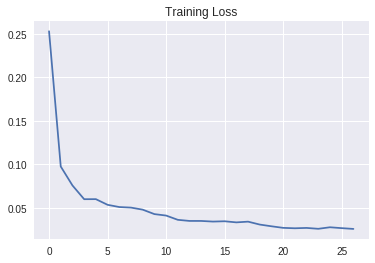

In [0]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()


Test the Trained Network

Test Data

In [0]:
def test(capsule_net, test_loader):
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
    
  test_loss = 0 # loss tracking

  capsule_net.eval() # eval mode

  for batch_i, (images, target) in enumerate(test_loader):
    target = torch.eye(10).index_select(dim=0, index=target)

    batch_size = images.size(0)

    if TRAIN_ON_GPU:
      images, target = images.cuda(), target.cuda()

    # forward pass: compute predicted outputs by passing inputs to the model
    caps_output, reconstructions, y = capsule_net(images)
    # calculate the loss
    loss = criterion(caps_output, target, images, reconstructions)
    # update average test loss 
    test_loss += loss.item()
    # convert output probabilities to predicted class
    _, pred = torch.max(y.data.cpu(), 1)
    _, target_shape = torch.max(target.data.cpu(), 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target_shape.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
      label = target_shape.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1

  # avg test loss
  avg_test_loss = test_loss/len(test_loader)
  print('Test Loss: {:.8f}\n'.format(avg_test_loss))

  for i in range(10):
    if class_total[i] > 0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
      str(i), 100 * class_correct[i] / class_total[i],
      np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))
    
  # return last batch of capsule vectors, images, reconstructions
  return caps_output, images, reconstructions

In [0]:
# call test function and get reconstructed images
caps_output, images, reconstructions = test(capsule_net, test_loader)

Test Loss: 0.03379168

Test Accuracy of     0: 99% (977/980)
Test Accuracy of     1: 99% (1131/1135)
Test Accuracy of     2: 98% (1019/1032)
Test Accuracy of     3: 98% (991/1010)
Test Accuracy of     4: 98% (972/982)
Test Accuracy of     5: 99% (886/892)
Test Accuracy of     6: 98% (947/958)
Test Accuracy of     7: 99% (1024/1028)
Test Accuracy of     8: 98% (962/974)
Test Accuracy of     9: 97% (981/1009)

Test Accuracy (Overall): 98% (9890/10000)


Display Reconstructions

In [0]:
def display_images(images, reconstructions):
  # convert to numpy images
  images = images.data.cpu().numpy()
  reconstructions = reconstructions.view(-1, 1, 28, 28)
  reconstructions = reconstructions.data.cpu().numpy()
    
  # plot the first ten input images and then reconstructed images
  fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(26,5))

  # input images on top row, reconstructions on bottom
  for images, row in zip([images, reconstructions], axes):
    for img, ax in zip(images, row):
      ax.imshow(np.squeeze(img), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

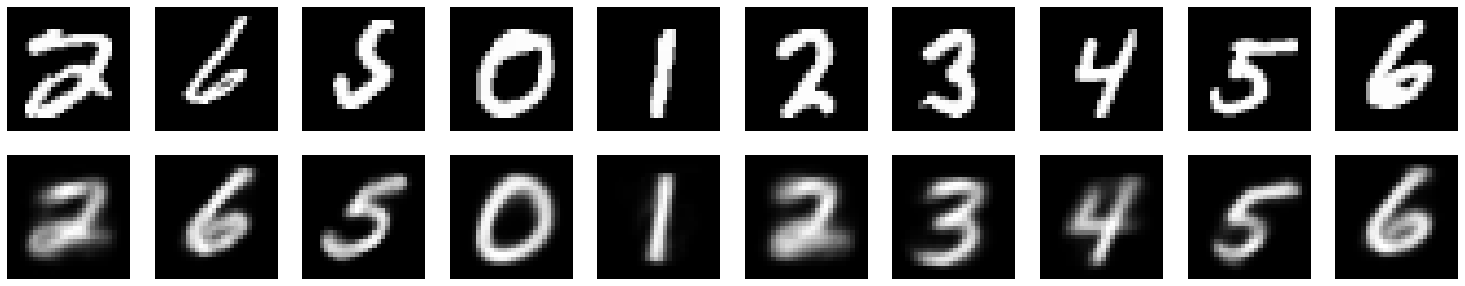

In [0]:
# display original and reconstructed images, in rows
display_images(images, reconstructions)

Response to Affine Transformations

In [0]:
# convert data to Tensor *and* perform random affine transformation
transform = transforms.Compose([transforms.RandomAffine(degrees=30, translate=(0.1,0.1)), transforms.ToTensor()])

# test dataset
transformed_test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# prepare data loader
transformed_test_loader = torch.utils.data.DataLoader(transformed_test_data, batch_size=batch_size, num_workers=num_workers)

Visualize transformed data

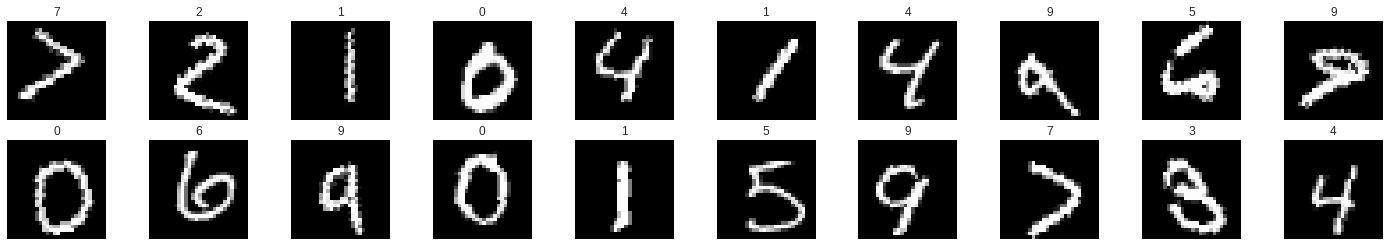

In [0]:
# obtain one batch of test images
dataiter = iter(transformed_test_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
  ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  # print out the correct label for each image
  # .item() gets the value contained in a Tensor
  ax.set_title(str(labels[idx].item()))

Testing on transformed test data

In [0]:
# call test function and get reconstructed images
_, images, reconstructions = test(capsule_net, transformed_test_loader)

Test Loss: 0.28022722

Test Accuracy of     0: 87% (857/980)
Test Accuracy of     1: 89% (1013/1135)
Test Accuracy of     2: 85% (879/1032)
Test Accuracy of     3: 82% (833/1010)
Test Accuracy of     4: 81% (803/982)
Test Accuracy of     5: 91% (818/892)
Test Accuracy of     6: 80% (772/958)
Test Accuracy of     7: 81% (841/1028)
Test Accuracy of     8: 73% (718/974)
Test Accuracy of     9: 74% (756/1009)

Test Accuracy (Overall): 82% (8290/10000)


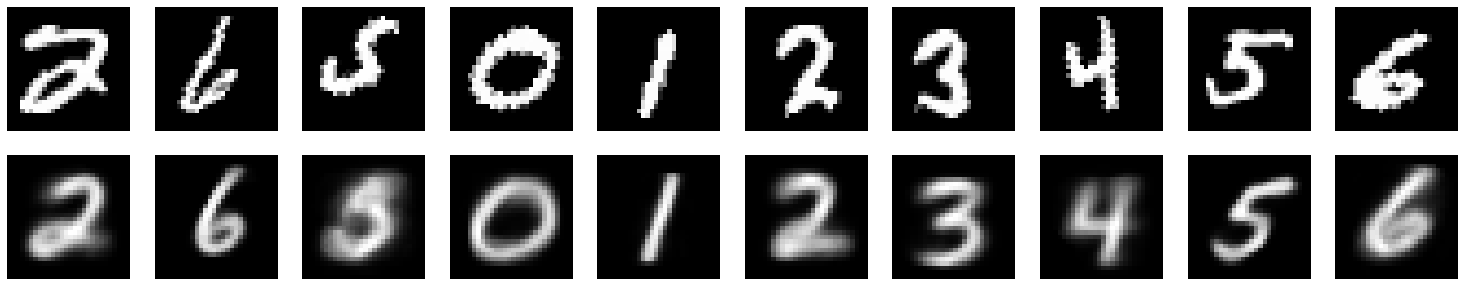

In [0]:
# original input images
display_images(images, reconstructions)

Capsule Output Vectors

In [0]:
def vector_analysis(capsule_net, x, select_idx=1):
  classes = (x ** 2).sum(dim=-1) ** 0.5
  classes = F.softmax(classes, dim=-1)

  # find the capsule with the maximum vector length
  # here, vector length indicates the probability of a class' existence
  _, max_length_indices = classes.max(dim=1)

  # create a sparse class matrix
  sparse_matrix = torch.eye(10) # 10 is the number of classes
  if TRAIN_ON_GPU:
    sparse_matrix = sparse_matrix.cuda()
  # get the class scores from the "correct" capsule
  y = sparse_matrix.index_select(dim=0, index=max_length_indices.data)

  # create reconstructed pixels
  x = x * y[:, :, None]
    
  # flatten image into a vector shape (batch_size, vector_dim)
  flattened_x = x.view(x.size(0), -1)
  # select a single image from a batch to work with
  flattened_x = flattened_x[select_idx]
    
  # track reconstructed images
  reconstructed_ims = []
  # values to change *one* vector dimension by
  perturb_range = np.arange(-0.25, 0.30, 0.05)
    
  # iterate through 16 vector dims
  for k in range(16):
    # create a copy of flattened_x to modify
    transformed_x = torch.zeros(*flattened_x.size()).cuda()
    transformed_x[:] = flattened_x[:]
    # iterate through each perturbation value
    for j in range(len(perturb_range)):
      # for each capsule output
      for i in range(10):
        transformed_x[k+(16*i)] = flattened_x[k+(16*i)]+perturb_range[j]

      # create reconstructed images
      reconstructions = capsule_net.decoder.linear_layers(transformed_x)
      # reshape into 28x28 image, (batch_size, depth, x, y)
      reconstructions = reconstructions.view(-1, 1, 28, 28)
      reconstructed_ims.append(reconstructions)
    
  # return final list of reconstructed ims    
  return reconstructed_ims

In [0]:
# call function and get perturbed reconstructions
reconstructed_ims = vector_analysis(capsule_net, caps_output, select_idx=1)

Display the reconstructions

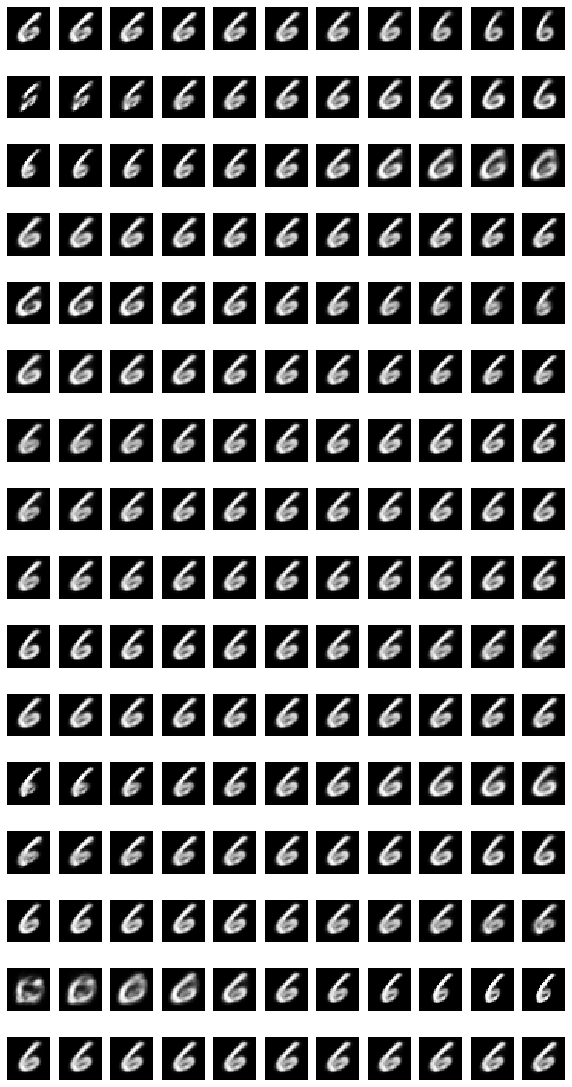

In [0]:
fig = plt.figure(figsize=(10, 20)) # define figsize

# display all ims
for idx in range(len(reconstructed_ims)):
  # convert to numpy images
  image = reconstructed_ims[idx]
  image = image.detach().cpu().numpy()
  # display 16 rows of images
  ax = fig.add_subplot(16, len(reconstructed_ims)/16, idx+1, xticks=[], yticks=[])
  ax.imshow(image.squeeze(), cmap='gray')

for more details visit this link

https://github.com/cezannec/capsule_net_pytorch/blob/master/Capsule_Network.ipynb